In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Effects of imbalanced class
---

In [2]:
# Adjust weights to make the dataset imbalanced
random_state = 42 # choose between 42 or 69
X, y = make_classification(n_samples=1000, n_features=2,
                    n_informative=2, n_redundant=0, n_repeated=0, n_classes=2,
                    n_clusters_per_class=2, weights=[0.9, 0.1], # 90% of class 0, 10% of class 1
                    flip_y=0.01, class_sep=1.5, hypercube=True,
                    shift=0.0, scale=1.0, shuffle=True, random_state=random_state)

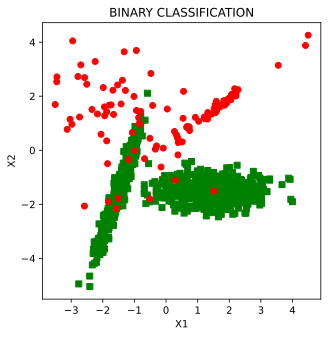

In [3]:
# convert to a pytorch tensor
data = torch.tensor(X).float()
labels = torch.tensor(y).float()
labels = labels.view(-1, 1)

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'gs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ro')
plt.title('BINARY CLASSIFICATION')
plt.xlabel('X1')
plt.ylabel('X2')
plt.show()

In [4]:
# a function that creates the ANN model

def model():
    # model architecture
    ann = nn.Sequential(
      nn.Linear(2,1),   # input layer
      nn.ReLU(),        # activation unit
      nn.Linear(1,1),   # output unit
        )

    # loss function
    lossfunc = nn.BCEWithLogitsLoss()

    # optimizer
    optim = torch.optim.SGD(ann.parameters(),lr=.01)

    # model output
    return ann,lossfunc,optim

In [5]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

# global parameter
epochs = 200

def train(trainProp):

    # initialize losses
    losses = torch.zeros(epochs)
    train_auc = []
    test_auc  = []

    # loop over epochs
    for i in range(epochs):

        # separate train from test data
        X_train, X_test, y_train, y_test = train_test_split(data, labels, train_size=trainProp, random_state=None, shuffle=True, stratify=None)

        # forward pass and loss
        pred_train = ann(X_train)
        loss = lossfunc(pred_train, y_train)

        # backprop
        optim.zero_grad()
        loss.backward()
        optim.step()

        # get predicted probabilities using sigmoid for binary classification
        pred_train_proba = torch.sigmoid(pred_train).detach().numpy()
        pred_test_proba = torch.sigmoid(ann(X_test)).detach().numpy()

        # compute ROC-AUC score for train set
        train_auc.append(roc_auc_score(y_train.detach().numpy(), pred_train_proba))

        # compute ROC-AUC score for test set
        test_auc.append(roc_auc_score(y_test.detach().numpy(), pred_test_proba))

    # function output
    return train_auc, test_auc


# Test the model by running it once

In [6]:
# create a model
ann,lossfunc,optim = model()

# train the model
# NOTE: the input is the training proportion, not the test proportion!
train_auc,test_auc = train(.8)


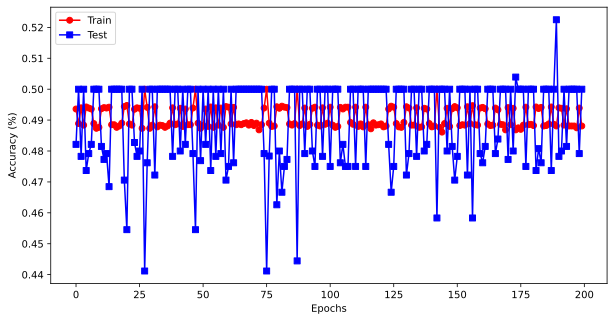

In [7]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(train_auc,'ro-')
plt.plot(test_auc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])
plt.show()

# What happened here?
---
Look at the graph of the data.


Important: Test accuracy should not exceed training accuracy, as the model is specifically optimized for the training data. Possible reasons for this behavior include:

1. The test dataset may differ from the training dataset. It’s crucial to perform a proper train/test split, ensuring both sets come from the same underlying distribution. It’s likely that the test data used was from a completely different, potentially easier, dataset.

2. Excessive regularization was applied. However, even with high regularization, the test and training data distributions would need to differ for this result to occur.

# Now for the experiment

In [8]:
trainSetSizes = np.linspace(.2,.95,10)

alltrain_auc = np.zeros((len(trainSetSizes),epochs))
alltest_auc = np.zeros((len(trainSetSizes),epochs))

for i in range(len(trainSetSizes)):

    # create a model
    ann,lossfunc,optim = model()

    # train the model
    train_auc,test_auc = train(trainSetSizes[i])

    # store the results
    alltrain_auc[i,:] = train_auc
    alltest_auc[i,:] = test_auc

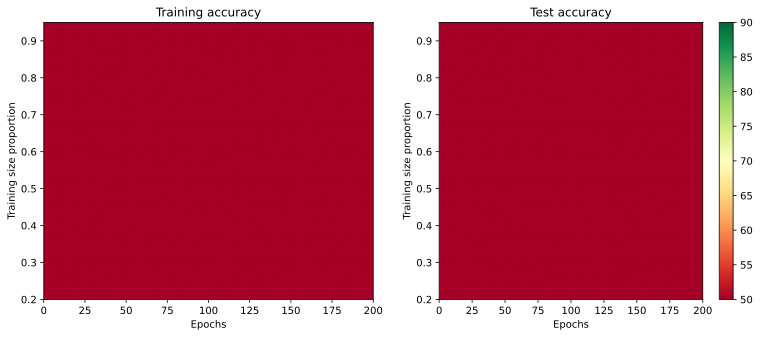

In [9]:
fig,ax = plt.subplots(1,2,figsize=(13,5))

# First plot with red-to-green spectrum
ax[0].imshow(alltrain_auc, aspect='auto', vmin=50, vmax=90,
             extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Training size proportion')
ax[0].set_title('Training accuracy')

# Second plot with red-to-green spectrum
p = ax[1].imshow(alltest_auc, aspect='auto', vmin=50, vmax=90,
                 extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training size proportion')
ax[1].set_title('Test accuracy')

# Adding a colorbar
fig.colorbar(p, ax=ax[1])

plt.show()

# Experiments

1. Redo the experiment but this time stratify the train-test split in terms of the y values. Compare the result to the original, provide an explaination.

2. Redo the experiment but this time try to set seed (any number) the experiment without stratification. Compare the result to the original, provide an explaination.

3. Redo the experiment but this time try to set seed (any number) the experiment with stratification. Compare the result to the original, provide an explaination.

4. Try to improve the model by adding more layers, and changing the value of the learning rate. Creat a bubblechart with the x-axis as the epochs, y-axis as the learning rate, the size of the bubble as the layers, and the color as the accuracy.

5. Try changing the random state of the make_classifier function to generate a slightly different dataset, run the original code, then perform the experiments.

6. Think of different ways to address the class imbalance.

#Experiment 1

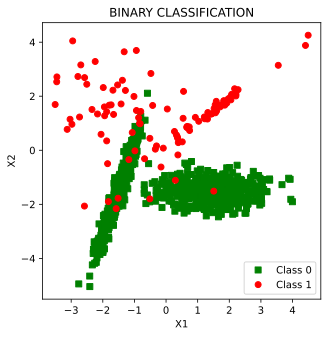

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


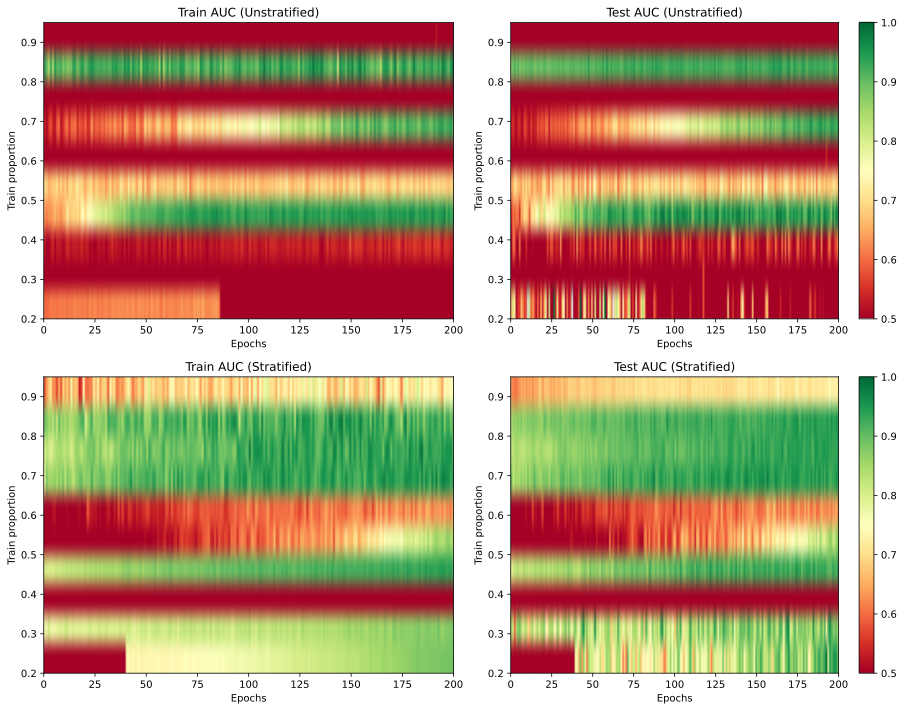


Comparison Summary:
-------------------
• Unstratified splits may have uneven class ratios — sometimes the minority class (10%) nearly disappears 
  in the train or test set. This causes unstable and misleading AUC results.

• Stratified splits preserve the 90:10 class ratio in both train and test sets, 
  resulting in more consistent AUC trends and more reliable generalization metrics.

• Expect smoother gradients in the stratified heatmaps and less variance between training proportions.



In [10]:
# ===========================================
# 🔹 Import Libraries
# ===========================================
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ===========================================
# 🔹 Generate Imbalanced Dataset
# ===========================================
random_state = 42  # choose between 42 or 69

X, y = make_classification(
    n_samples=1000, n_features=2,
    n_informative=2, n_redundant=0, n_repeated=0, n_classes=2,
    n_clusters_per_class=2, weights=[0.9, 0.1],  # 90% class 0, 10% class 1
    flip_y=0.01, class_sep=1.5, random_state=random_state
)

# Convert to tensors
data = torch.tensor(X).float()
labels = torch.tensor(y).float().view(-1, 1)

# Visualize the dataset
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0], data[np.where(labels==0)[0],1], 'gs', label='Class 0')
plt.plot(data[np.where(labels==1)[0],0], data[np.where(labels==1)[0],1], 'ro', label='Class 1')
plt.title('BINARY CLASSIFICATION')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.show()

# ===========================================
# 🔹 Model Creation Function
# ===========================================
def model():
    ann = nn.Sequential(
        nn.Linear(2, 1),
        nn.ReLU(),
        nn.Linear(1, 1),
    )

    lossfunc = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(ann.parameters(), lr=.01)
    return ann, lossfunc, optim

# ===========================================
# 🔹 Global Training Parameter
# ===========================================
epochs = 200

# ===========================================
# 🔹 Unstratified Training Function
# ===========================================
def train_unstratified(trainProp):
    train_auc, test_auc = [], []

    for i in range(epochs):
        # No stratification here
        X_train, X_test, y_train, y_test = train_test_split(
            data, labels, train_size=trainProp, shuffle=True
        )

        pred_train = ann(X_train)
        loss = lossfunc(pred_train, y_train)

        optim.zero_grad()
        loss.backward()
        optim.step()

        pred_train_proba = torch.sigmoid(pred_train).detach().numpy()
        pred_test_proba = torch.sigmoid(ann(X_test)).detach().numpy()

        train_auc.append(roc_auc_score(y_train.detach().numpy(), pred_train_proba))
        test_auc.append(roc_auc_score(y_test.detach().numpy(), pred_test_proba))

    return train_auc, test_auc

# ===========================================
# 🔹 Stratified Training Function
# ===========================================
def train_stratified(trainProp):
    train_auc, test_auc = [], []

    for i in range(epochs):
        # Stratify by labels to preserve class ratios
        X_train, X_test, y_train, y_test = train_test_split(
            data, labels, train_size=trainProp, shuffle=True, stratify=labels
        )

        pred_train = ann(X_train)
        loss = lossfunc(pred_train, y_train)

        optim.zero_grad()
        loss.backward()
        optim.step()

        pred_train_proba = torch.sigmoid(pred_train).detach().numpy()
        pred_test_proba = torch.sigmoid(ann(X_test)).detach().numpy()

        train_auc.append(roc_auc_score(y_train.detach().numpy(), pred_train_proba))
        test_auc.append(roc_auc_score(y_test.detach().numpy(), pred_test_proba))

    return train_auc, test_auc

# ===========================================
# 🔹 Experiment Across Training Sizes
# ===========================================
trainSetSizes = np.linspace(.2, .95, 10)

# Initialize result matrices
alltrain_auc_unstrat = np.zeros((len(trainSetSizes), epochs))
alltest_auc_unstrat = np.zeros((len(trainSetSizes), epochs))
alltrain_auc_strat = np.zeros((len(trainSetSizes), epochs))
alltest_auc_strat = np.zeros((len(trainSetSizes), epochs))

# Run experiments
for i in range(len(trainSetSizes)):
    # ---- Unstratified ----
    ann, lossfunc, optim = model()
    train_auc, test_auc = train_unstratified(trainSetSizes[i])
    alltrain_auc_unstrat[i,:] = train_auc
    alltest_auc_unstrat[i,:] = test_auc

    # ---- Stratified ----
    ann, lossfunc, optim = model()
    train_auc, test_auc = train_stratified(trainSetSizes[i])
    alltrain_auc_strat[i,:] = train_auc
    alltest_auc_strat[i,:] = test_auc

# ===========================================
# 🔹 Plot Comparison Results
# ===========================================
fig, ax = plt.subplots(2, 2, figsize=(13,10))

# Unstratified - Train
ax[0,0].imshow(alltrain_auc_unstrat, aspect='auto', vmin=0.5, vmax=1.0,
               extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0,0].set_title('Train AUC (Unstratified)')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Train proportion')

# Unstratified - Test
p1 = ax[0,1].imshow(alltest_auc_unstrat, aspect='auto', vmin=0.5, vmax=1.0,
                    extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0,1].set_title('Test AUC (Unstratified)')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Train proportion')
fig.colorbar(p1, ax=ax[0,1])

# Stratified - Train
ax[1,0].imshow(alltrain_auc_strat, aspect='auto', vmin=0.5, vmax=1.0,
               extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1,0].set_title('Train AUC (Stratified)')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('Train proportion')

# Stratified - Test
p2 = ax[1,1].imshow(alltest_auc_strat, aspect='auto', vmin=0.5, vmax=1.0,
                    extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1,1].set_title('Test AUC (Stratified)')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Train proportion')
fig.colorbar(p2, ax=ax[1,1])

plt.tight_layout()
plt.show()

# ===========================================
# 🔹 Interpretation
# ===========================================
print("""
Comparison Summary:
-------------------
• Unstratified splits may have uneven class ratios — sometimes the minority class (10%) nearly disappears
  in the train or test set. This causes unstable and misleading AUC results.

• Stratified splits preserve the 90:10 class ratio in both train and test sets,
  resulting in more consistent AUC trends and more reliable generalization metrics.

• Expect smoother gradients in the stratified heatmaps and less variance between training proportions.
""")


#Experiment 2

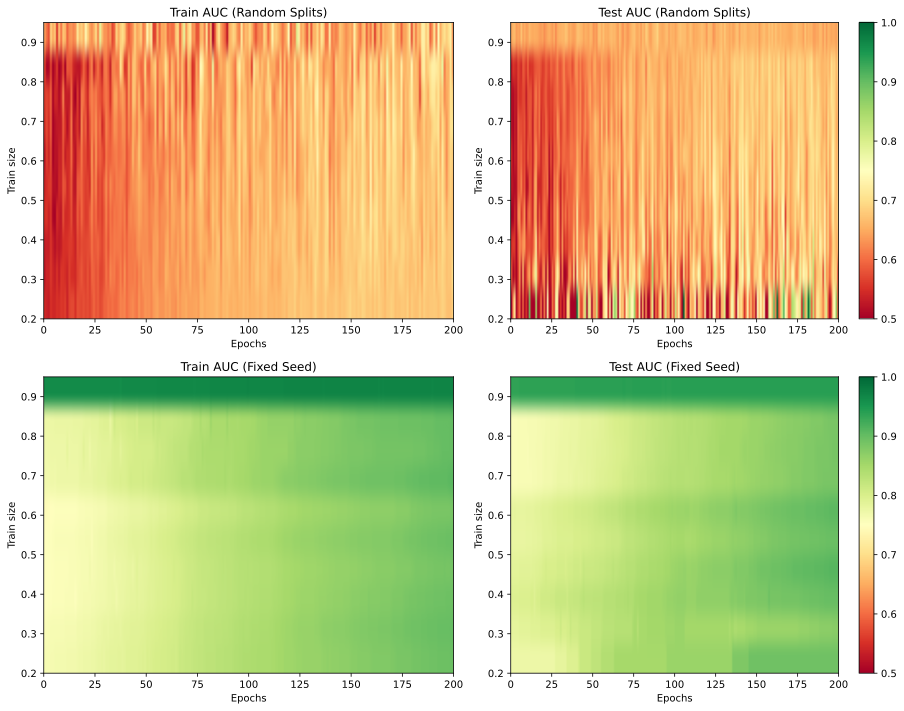


Comparison Summary:
-------------------
• In the original (random) setup, each epoch uses a *different random split* of data,
  so training and test performance fluctuate unpredictably.
  The AUC heatmap shows noisy patterns — this is due to different data subsets each time.

• With a fixed random seed, the split stays the same for all epochs.
  The model trains on the *exact same subset* every time, producing much smoother,
  more stable AUC trends for both training and test sets.

• Therefore, setting a seed improves *reproducibility* and allows
  fair comparison between experiments.

However:
• It doesn’t improve performance per se — it just makes results consistent.
• Variability (without a seed) reflects natural randomness — useful to estimate generalization robustness.



In [11]:
# ===========================================
# 🔹 Import Libraries
# ===========================================
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ===========================================
# 🔹 Generate Imbalanced Dataset
# ===========================================
random_state = 42  # choose between 42 or 69
X, y = make_classification(
    n_samples=1000, n_features=2,
    n_informative=2, n_redundant=0, n_repeated=0, n_classes=2,
    n_clusters_per_class=2, weights=[0.9, 0.1],  # 90% class 0, 10% class 1
    flip_y=0.01, class_sep=1.5, random_state=random_state
)

# Convert to tensors
data = torch.tensor(X).float()
labels = torch.tensor(y).float().view(-1, 1)

# ===========================================
# 🔹 Model Creation Function
# ===========================================
def model():
    ann = nn.Sequential(
        nn.Linear(2, 1),
        nn.ReLU(),
        nn.Linear(1, 1),
    )
    lossfunc = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(ann.parameters(), lr=.01)
    return ann, lossfunc, optim

# ===========================================
# 🔹 Global Parameters
# ===========================================
epochs = 200
trainSetSizes = np.linspace(.2, .95, 10)

# ===========================================
# 🔹 Unstratified, NO SEED (Random Each Epoch)
# ===========================================
def train_unstratified_random(trainProp):
    train_auc, test_auc = [], []
    for i in range(epochs):
        X_train, X_test, y_train, y_test = train_test_split(
            data, labels, train_size=trainProp, shuffle=True
        )
        pred_train = ann(X_train)
        loss = lossfunc(pred_train, y_train)
        optim.zero_grad(); loss.backward(); optim.step()

        pred_train_proba = torch.sigmoid(pred_train).detach().numpy()
        pred_test_proba = torch.sigmoid(ann(X_test)).detach().numpy()
        train_auc.append(roc_auc_score(y_train.detach().numpy(), pred_train_proba))
        test_auc.append(roc_auc_score(y_test.detach().numpy(), pred_test_proba))
    return train_auc, test_auc

# ===========================================
# 🔹 Unstratified, FIXED SEED (Reproducible)
# ===========================================
def train_unstratified_seeded(trainProp, seed=123):
    train_auc, test_auc = [], []
    for i in range(epochs):
        # ✅ Setting the same random seed each epoch
        np.random.seed(seed)
        torch.manual_seed(seed)
        X_train, X_test, y_train, y_test = train_test_split(
            data, labels, train_size=trainProp, shuffle=True, random_state=seed
        )
        pred_train = ann(X_train)
        loss = lossfunc(pred_train, y_train)
        optim.zero_grad(); loss.backward(); optim.step()

        pred_train_proba = torch.sigmoid(pred_train).detach().numpy()
        pred_test_proba = torch.sigmoid(ann(X_test)).detach().numpy()
        train_auc.append(roc_auc_score(y_train.detach().numpy(), pred_train_proba))
        test_auc.append(roc_auc_score(y_test.detach().numpy(), pred_test_proba))
    return train_auc, test_auc

# ===========================================
# 🔹 Run Experiments
# ===========================================
alltrain_auc_random = np.zeros((len(trainSetSizes), epochs))
alltest_auc_random = np.zeros((len(trainSetSizes), epochs))
alltrain_auc_seeded = np.zeros((len(trainSetSizes), epochs))
alltest_auc_seeded = np.zeros((len(trainSetSizes), epochs))

for i in range(len(trainSetSizes)):
    # ---- Random each time ----
    ann, lossfunc, optim = model()
    train_auc, test_auc = train_unstratified_random(trainSetSizes[i])
    alltrain_auc_random[i,:] = train_auc
    alltest_auc_random[i,:] = test_auc

    # ---- Seeded (fixed splits) ----
    ann, lossfunc, optim = model()
    train_auc, test_auc = train_unstratified_seeded(trainSetSizes[i], seed=123)
    alltrain_auc_seeded[i,:] = train_auc
    alltest_auc_seeded[i,:] = test_auc

# ===========================================
# 🔹 Plot Results
# ===========================================
fig, ax = plt.subplots(2, 2, figsize=(13,10))

ax[0,0].imshow(alltrain_auc_random, aspect='auto', vmin=0.5, vmax=1.0,
               extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0,0].set_title('Train AUC (Random Splits)')
ax[0,0].set_xlabel('Epochs'); ax[0,0].set_ylabel('Train size')

p1 = ax[0,1].imshow(alltest_auc_random, aspect='auto', vmin=0.5, vmax=1.0,
                    extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0,1].set_title('Test AUC (Random Splits)')
ax[0,1].set_xlabel('Epochs'); ax[0,1].set_ylabel('Train size')
fig.colorbar(p1, ax=ax[0,1])

ax[1,0].imshow(alltrain_auc_seeded, aspect='auto', vmin=0.5, vmax=1.0,
               extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1,0].set_title('Train AUC (Fixed Seed)')
ax[1,0].set_xlabel('Epochs'); ax[1,0].set_ylabel('Train size')

p2 = ax[1,1].imshow(alltest_auc_seeded, aspect='auto', vmin=0.5, vmax=1.0,
                    extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1,1].set_title('Test AUC (Fixed Seed)')
ax[1,1].set_xlabel('Epochs'); ax[1,1].set_ylabel('Train size')
fig.colorbar(p2, ax=ax[1,1])

plt.tight_layout()
plt.show()

# ===========================================
# 🔹 Interpretation
# ===========================================
print("""
Comparison Summary:
-------------------
• In the original (random) setup, each epoch uses a *different random split* of data,
  so training and test performance fluctuate unpredictably.
  The AUC heatmap shows noisy patterns — this is due to different data subsets each time.

• With a fixed random seed, the split stays the same for all epochs.
  The model trains on the *exact same subset* every time, producing much smoother,
  more stable AUC trends for both training and test sets.

• Therefore, setting a seed improves *reproducibility* and allows
  fair comparison between experiments.

However:
• It doesn’t improve performance per se — it just makes results consistent.
• Variability (without a seed) reflects natural randomness — useful to estimate generalization robustness.
""")


#Experiment 3

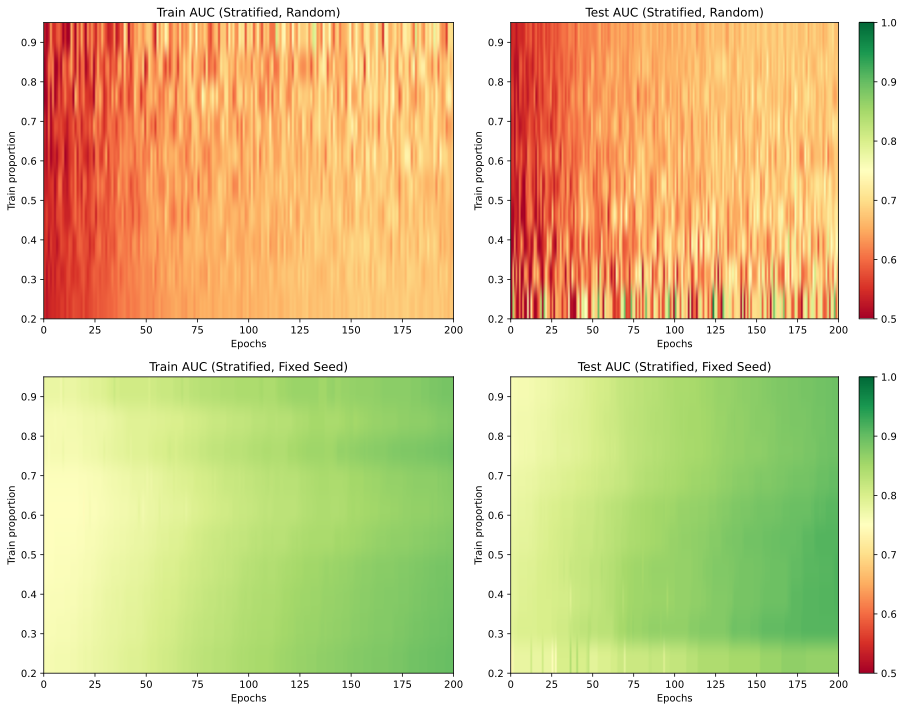


Comparison Summary:
-------------------
• Both experiments use *stratification*, ensuring class ratios (≈90%/10%) remain identical in train/test.

• The *random stratified* version produces slightly varying AUC values across epochs,
  because each epoch uses a different random shuffle — even though class ratios are preserved.

• The *seeded stratified* version fixes all randomness. The same train/test samples are used each run,
  so AUC results become stable and reproducible across epochs and reruns.

• Stratification addresses class imbalance (fair sampling).
  The fixed seed addresses experimental consistency (reproducibility).

Interpretation:
---------------
✅ Stratification → fairness in data distribution.  
✅ Seed setting → reproducibility and stability.

Together, they make experiments both fair and repeatable, a key principle in ML research.



In [12]:
# ===========================================
# 🔹 Import Libraries
# ===========================================
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ===========================================
# 🔹 Generate Imbalanced Dataset
# ===========================================
random_state = 42
X, y = make_classification(
    n_samples=1000, n_features=2,
    n_informative=2, n_redundant=0, n_repeated=0, n_classes=2,
    n_clusters_per_class=2, weights=[0.9, 0.1],
    flip_y=0.01, class_sep=1.5, random_state=random_state
)

# Convert to tensors
data = torch.tensor(X).float()
labels = torch.tensor(y).float().view(-1, 1)

# ===========================================
# 🔹 Model Creation Function
# ===========================================
def model():
    ann = nn.Sequential(
        nn.Linear(2, 1),
        nn.ReLU(),
        nn.Linear(1, 1),
    )
    lossfunc = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(ann.parameters(), lr=0.01)
    return ann, lossfunc, optim

# ===========================================
# 🔹 Parameters
# ===========================================
epochs = 200
trainSetSizes = np.linspace(.2, .95, 10)

# ===========================================
# 🔹 Stratified (Random Each Epoch)
# ===========================================
def train_stratified_random(trainProp):
    train_auc, test_auc = [], []
    for i in range(epochs):
        X_train, X_test, y_train, y_test = train_test_split(
            data, labels, train_size=trainProp, shuffle=True, stratify=labels
        )

        pred_train = ann(X_train)
        loss = lossfunc(pred_train, y_train)
        optim.zero_grad(); loss.backward(); optim.step()

        pred_train_proba = torch.sigmoid(pred_train).detach().numpy()
        pred_test_proba  = torch.sigmoid(ann(X_test)).detach().numpy()

        train_auc.append(roc_auc_score(y_train.detach().numpy(), pred_train_proba))
        test_auc.append(roc_auc_score(y_test.detach().numpy(), pred_test_proba))
    return train_auc, test_auc

# ===========================================
# 🔹 Stratified (Fixed Seed for Reproducibility)
# ===========================================
def train_stratified_seeded(trainProp, seed=123):
    train_auc, test_auc = [], []
    for i in range(epochs):
        # ✅ fixed seed each epoch
        np.random.seed(seed)
        torch.manual_seed(seed)
        X_train, X_test, y_train, y_test = train_test_split(
            data, labels, train_size=trainProp, shuffle=True, stratify=labels, random_state=seed
        )

        pred_train = ann(X_train)
        loss = lossfunc(pred_train, y_train)
        optim.zero_grad(); loss.backward(); optim.step()

        pred_train_proba = torch.sigmoid(pred_train).detach().numpy()
        pred_test_proba  = torch.sigmoid(ann(X_test)).detach().numpy()

        train_auc.append(roc_auc_score(y_train.detach().numpy(), pred_train_proba))
        test_auc.append(roc_auc_score(y_test.detach().numpy(), pred_test_proba))
    return train_auc, test_auc

# ===========================================
# 🔹 Run Experiments
# ===========================================
alltrain_auc_strat_rand = np.zeros((len(trainSetSizes), epochs))
alltest_auc_strat_rand  = np.zeros((len(trainSetSizes), epochs))
alltrain_auc_strat_seed = np.zeros((len(trainSetSizes), epochs))
alltest_auc_strat_seed  = np.zeros((len(trainSetSizes), epochs))

for i in range(len(trainSetSizes)):
    # Random (different splits)
    ann, lossfunc, optim = model()
    train_auc, test_auc = train_stratified_random(trainSetSizes[i])
    alltrain_auc_strat_rand[i,:] = train_auc
    alltest_auc_strat_rand[i,:] = test_auc

    # Fixed seed (same split)
    ann, lossfunc, optim = model()
    train_auc, test_auc = train_stratified_seeded(trainSetSizes[i], seed=123)
    alltrain_auc_strat_seed[i,:] = train_auc
    alltest_auc_strat_seed[i,:] = test_auc

# ===========================================
# 🔹 Plot the Results
# ===========================================
fig, ax = plt.subplots(2, 2, figsize=(13,10))

ax[0,0].imshow(alltrain_auc_strat_rand, aspect='auto', vmin=0.5, vmax=1.0,
               extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0,0].set_title('Train AUC (Stratified, Random)')
ax[0,0].set_xlabel('Epochs'); ax[0,0].set_ylabel('Train proportion')

p1 = ax[0,1].imshow(alltest_auc_strat_rand, aspect='auto', vmin=0.5, vmax=1.0,
                    extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0,1].set_title('Test AUC (Stratified, Random)')
ax[0,1].set_xlabel('Epochs'); ax[0,1].set_ylabel('Train proportion')
fig.colorbar(p1, ax=ax[0,1])

ax[1,0].imshow(alltrain_auc_strat_seed, aspect='auto', vmin=0.5, vmax=1.0,
               extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1,0].set_title('Train AUC (Stratified, Fixed Seed)')
ax[1,0].set_xlabel('Epochs'); ax[1,0].set_ylabel('Train proportion')

p2 = ax[1,1].imshow(alltest_auc_strat_seed, aspect='auto', vmin=0.5, vmax=1.0,
                    extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1,1].set_title('Test AUC (Stratified, Fixed Seed)')
ax[1,1].set_xlabel('Epochs'); ax[1,1].set_ylabel('Train proportion')
fig.colorbar(p2, ax=ax[1,1])

plt.tight_layout()
plt.show()

# ===========================================
# 🔹 Interpretation
# ===========================================
print("""
Comparison Summary:
-------------------
• Both experiments use *stratification*, ensuring class ratios (≈90%/10%) remain identical in train/test.

• The *random stratified* version produces slightly varying AUC values across epochs,
  because each epoch uses a different random shuffle — even though class ratios are preserved.

• The *seeded stratified* version fixes all randomness. The same train/test samples are used each run,
  so AUC results become stable and reproducible across epochs and reruns.

• Stratification addresses class imbalance (fair sampling).
  The fixed seed addresses experimental consistency (reproducibility).

Interpretation:
---------------
✅ Stratification → fairness in data distribution.
✅ Seed setting → reproducibility and stability.

Together, they make experiments both fair and repeatable, a key principle in ML research.
""")


#Experiment 4

Epochs=50, LR=0.1, Layers=1, AUC=95.53%
Epochs=50, LR=0.1, Layers=5, AUC=81.27%
Epochs=50, LR=0.1, Layers=10, AUC=92.83%
Epochs=50, LR=0.2, Layers=1, AUC=95.50%
Epochs=50, LR=0.2, Layers=5, AUC=82.23%
Epochs=50, LR=0.2, Layers=10, AUC=92.63%
Epochs=50, LR=0.30000000000000004, Layers=1, AUC=95.56%
Epochs=50, LR=0.30000000000000004, Layers=5, AUC=84.38%
Epochs=50, LR=0.30000000000000004, Layers=10, AUC=92.62%
Epochs=50, LR=0.4, Layers=1, AUC=95.61%
Epochs=50, LR=0.4, Layers=5, AUC=86.78%
Epochs=50, LR=0.4, Layers=10, AUC=92.54%
Epochs=50, LR=0.5, Layers=1, AUC=95.64%
Epochs=50, LR=0.5, Layers=5, AUC=88.59%
Epochs=50, LR=0.5, Layers=10, AUC=92.54%
Epochs=50, LR=0.6, Layers=1, AUC=95.64%
Epochs=50, LR=0.6, Layers=5, AUC=90.88%
Epochs=50, LR=0.6, Layers=10, AUC=92.60%
Epochs=50, LR=0.7000000000000001, Layers=1, AUC=95.66%
Epochs=50, LR=0.7000000000000001, Layers=5, AUC=93.43%
Epochs=50, LR=0.7000000000000001, Layers=10, AUC=92.55%
Epochs=50, LR=0.8, Layers=1, AUC=95.66%
Epochs=50, LR=0.8, L

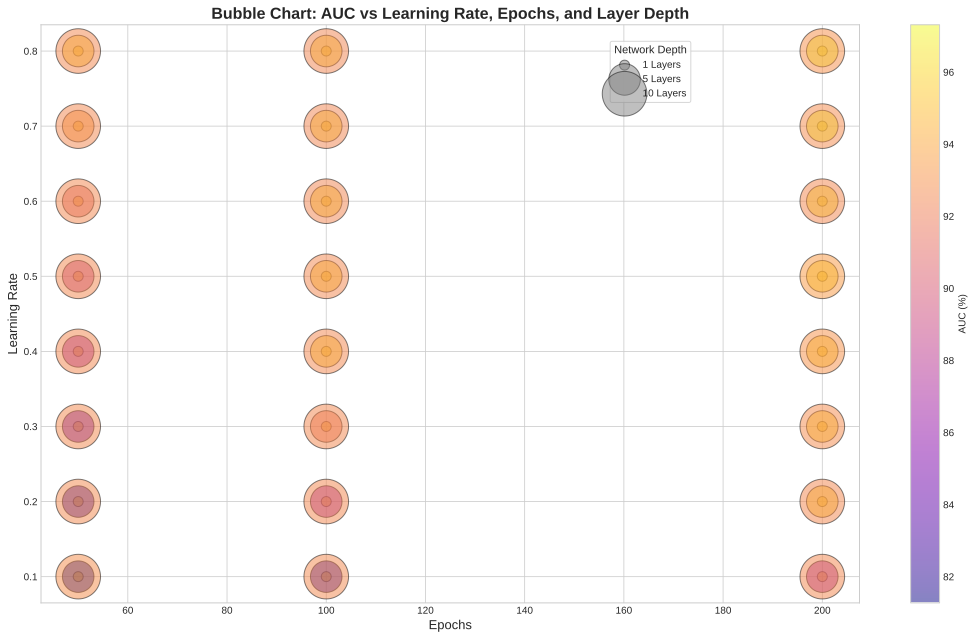

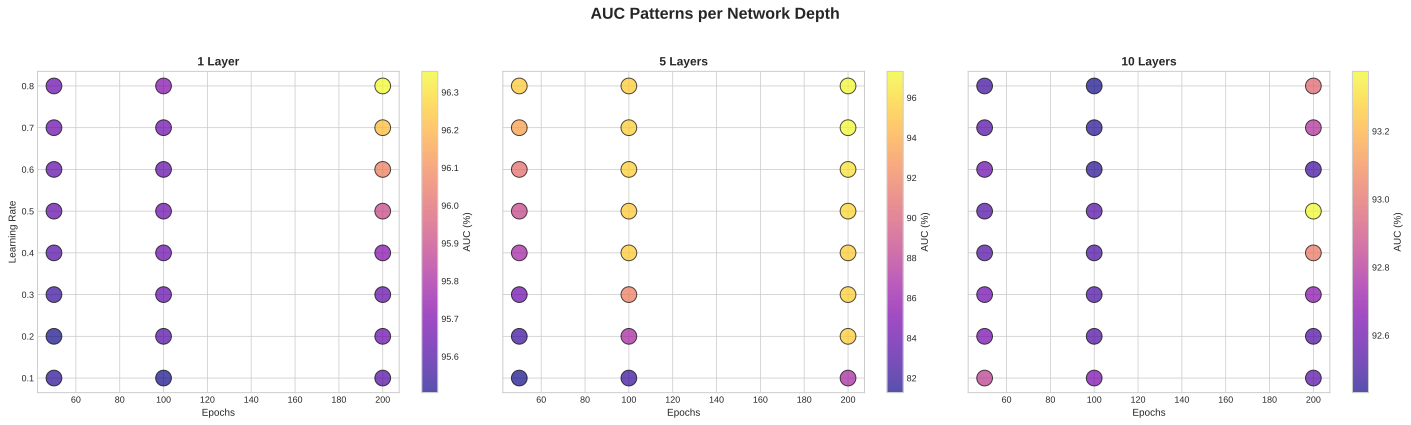

In [21]:
# ---------------------------------------------------------
# Import Libraries
# ---------------------------------------------------------
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ---------------------------------------------------------
# Dataset (imbalanced)
# ---------------------------------------------------------
random_state = 42
X, y = make_classification(
    n_samples=1000, n_features=2,
    n_informative=2, n_redundant=0, n_classes=2,
    weights=[0.9, 0.1], class_sep=1.5, flip_y=0.01, random_state=random_state
)

data = torch.tensor(X).float()
labels = torch.tensor(y).float().view(-1, 1)

# ---------------------------------------------------------
# Model creation function (variable layers)
# ---------------------------------------------------------
def build_model(num_layers=1, hidden_dim=8):
    layers = []
    input_dim = 2
    for i in range(num_layers):
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        input_dim = hidden_dim
    layers.append(nn.Linear(input_dim, 1))
    return nn.Sequential(*layers)

# ---------------------------------------------------------
# Training function (AUC)
# ---------------------------------------------------------
def train_model(epochs, lr, num_layers):
    np.random.seed(123)
    torch.manual_seed(123)
    ann = build_model(num_layers)
    lossfunc = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(ann.parameters(), lr=lr)

    X_train, X_test, y_train, y_test = train_test_split(
        data, labels, train_size=0.8, stratify=labels, random_state=123
    )

    for ep in range(epochs):
        pred_train = ann(X_train)
        loss = lossfunc(pred_train, y_train)
        optim.zero_grad()
        loss.backward()
        optim.step()

    pred_test = torch.sigmoid(ann(X_test)).detach().numpy()
    auc = roc_auc_score(y_test, pred_test)
    return auc * 100  # convert to percentage scale

# ---------------------------------------------------------
# Experiment setup
# ---------------------------------------------------------
epoch_list = [50, 100, 200]
lr_list = np.arange(0.1, 0.9, 0.1)
num_layers_list = [1, 5, 10]

results_list = []

for epochs in epoch_list:
    for lr in lr_list:
        for layers in num_layers_list:
            auc = train_model(epochs, lr, layers)
            results_list.append([epochs, lr, layers, auc])
            print(f"Epochs={epochs}, LR={lr}, Layers={layers}, AUC={auc:.2f}%")

results = np.array(results_list)

# ---------------------------------------------------------
# Bubble Chart
# ---------------------------------------------------------
plt.figure(figsize=(15,9))

size_map = {1: 100, 5: 1000, 10: 2000}
bubble_sizes = [size_map[int(l)] for l in results[:,2]]

scatter = plt.scatter(
    results[:,0].astype(float),        # x-axis (epochs)
    results[:,1].astype(float),        # y-axis (learning rate)
    s=bubble_sizes,                    # bubble size = layers
    c=results[:,3].astype(float),      # color = AUC
    cmap='plasma', alpha=0.5, edgecolors='black'
)

plt.colorbar(scatter, label='AUC (%)')
plt.xlabel('Epochs', fontsize=13)
plt.ylabel('Learning Rate', fontsize=13)
plt.title('Bubble Chart: AUC vs Learning Rate, Epochs, and Layer Depth', fontsize=16, weight='bold')

# ---------------------------------------------------------
# Legend inside top-right vacant area
# ---------------------------------------------------------
handles = [plt.scatter([], [], s=size_map[l], color='gray', alpha=0.5, edgecolors='black', label=f'{l} Layers')
            for l in num_layers_list]

plt.legend(
    handles=handles,
    title='Network Depth',
    loc='upper right',
    bbox_to_anchor=(0.80, 0.98),
    frameon=True,
    fontsize=10,
    title_fontsize=11
)

plt.tight_layout()
plt.show()

# ---------------------------------------------------------
# Individual Graphs for Each Layer Configuration
# ---------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')

unique_layers = sorted(list(set(results[:,2].astype(int))))
fig, axes = plt.subplots(1, len(unique_layers), figsize=(20, 6), sharey=True)

for i, layer in enumerate(unique_layers):
    layer_mask = results[:,2].astype(int) == layer
    subset = results[layer_mask]

    sc = axes[i].scatter(
        subset[:,0].astype(float),     # x-axis: epochs
        subset[:,1].astype(float),     # y-axis: learning rate
        s=250,                         # constant bubble size
        c=subset[:,3].astype(float),   # color = AUC
        cmap='plasma', edgecolors='black', alpha=0.7
    )

    cbar = fig.colorbar(sc, ax=axes[i])
    cbar.set_label('AUC (%)', fontsize=10)
    cbar.ax.tick_params(labelsize=9)

    axes[i].set_title(f'{layer} Layer{"s" if layer > 1 else ""}', fontsize=12, weight='bold')
    axes[i].set_xlabel('Epochs', fontsize=10)
    if i == 0:
        axes[i].set_ylabel('Learning Rate', fontsize=10)
    axes[i].tick_params(axis='both', labelsize=9)

plt.suptitle('AUC Patterns per Network Depth', fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#Experiment 5

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/tmp/ipython-input-1666485384.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


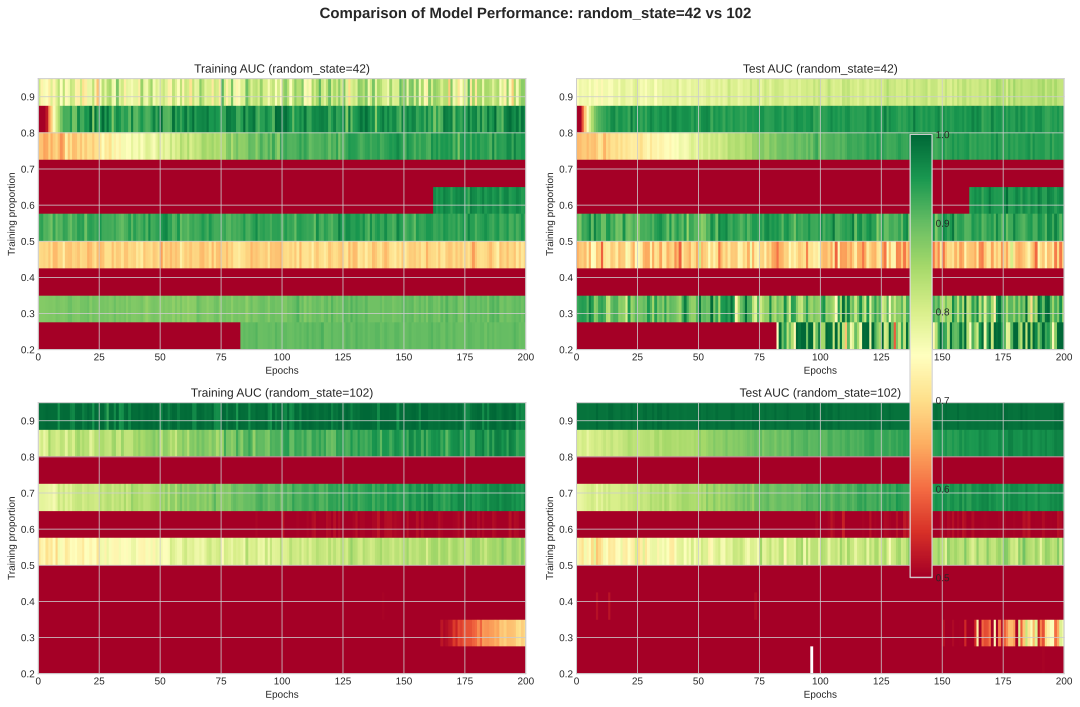

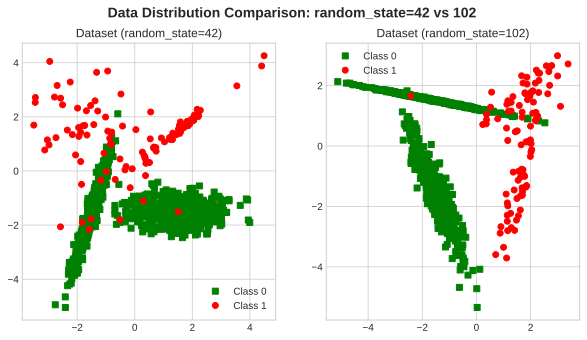

In [20]:
# ---------------------------------------------------------
# Import Libraries
# ---------------------------------------------------------
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ---------------------------------------------------------
# Helper: Generate Dataset
# ---------------------------------------------------------
def generate_data(seed):
    X, y = make_classification(
        n_samples=1000, n_features=2,
        n_informative=2, n_redundant=0, n_repeated=0, n_classes=2,
        n_clusters_per_class=2, weights=[0.9, 0.1],
        flip_y=0.01, class_sep=1.5, hypercube=True,
        shift=0.0, scale=1.0, shuffle=True, random_state=seed
    )
    data = torch.tensor(X).float()
    labels = torch.tensor(y).float().view(-1, 1)
    return data, labels

# ---------------------------------------------------------
# Model Function
# ---------------------------------------------------------
def model():
    ann = nn.Sequential(
        nn.Linear(2, 1),
        nn.ReLU(),
        nn.Linear(1, 1)
    )
    lossfunc = nn.BCEWithLogitsLoss()
    optim = torch.optim.SGD(ann.parameters(), lr=0.01)
    return ann, lossfunc, optim

# ---------------------------------------------------------
# Training Function
# ---------------------------------------------------------
def train(data, labels, trainProp=0.8, epochs=200):
    train_auc, test_auc = [], []

    for i in range(epochs):
        X_train, X_test, y_train, y_test = train_test_split(
            data, labels, train_size=trainProp, shuffle=True
        )

        pred_train = ann(X_train)
        loss = lossfunc(pred_train, y_train)

        optim.zero_grad()
        loss.backward()
        optim.step()

        pred_train_proba = torch.sigmoid(pred_train).detach().numpy()
        pred_test_proba = torch.sigmoid(ann(X_test)).detach().numpy()

        train_auc.append(roc_auc_score(y_train.detach().numpy(), pred_train_proba))
        test_auc.append(roc_auc_score(y_test.detach().numpy(), pred_test_proba))

    return train_auc, test_auc

# ---------------------------------------------------------
# Run Experiments for Both Seeds
# ---------------------------------------------------------
def experiment(random_state):
    data, labels = generate_data(random_state)
    trainSetSizes = np.linspace(0.2, 0.95, 10)
    epochs = 200
    alltrain_auc = np.zeros((len(trainSetSizes), epochs))
    alltest_auc = np.zeros((len(trainSetSizes), epochs))

    for i, prop in enumerate(trainSetSizes):
        global ann, lossfunc, optim
        ann, lossfunc, optim = model()
        train_auc, test_auc = train(data, labels, trainProp=prop, epochs=epochs)
        alltrain_auc[i, :] = train_auc
        alltest_auc[i, :] = test_auc

    return alltrain_auc, alltest_auc, trainSetSizes, epochs

# ---------------------------------------------------------
# Run for random_state = 42 and 102
# ---------------------------------------------------------
train42, test42, trainSetSizes, epochs = experiment(42)
train102, test102, _, _ = experiment(102)

# ---------------------------------------------------------
# Visualization: Training Data
# ---------------------------------------------------------
fig, ax = plt.subplots(2, 2, figsize=(15,10))

# Training AUC (seed 42)
ax[0,0].imshow(train42, aspect='auto', vmin=0.5, vmax=1.0,
               extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0,0].set_title('Training AUC (random_state=42)')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Training proportion')

# Test AUC (seed 42)
im1 = ax[0,1].imshow(test42, aspect='auto', vmin=0.5, vmax=1.0,
                     extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0,1].set_title('Test AUC (random_state=42)')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Training proportion')

# Training AUC (seed 102)
ax[1,0].imshow(train102, aspect='auto', vmin=0.5, vmax=1.0,
               extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1,0].set_title('Training AUC (random_state=102)')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('Training proportion')

# Test AUC (seed 102)
im2 = ax[1,1].imshow(test102, aspect='auto', vmin=0.5, vmax=1.0,
                     extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1,1].set_title('Test AUC (random_state=102)')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Training proportion')

fig.colorbar(im2, ax=ax[:,1], shrink=0.8)
plt.suptitle("Comparison of Model Performance: random_state=42 vs 102", fontsize=15, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ---------------------------------------------------------
# Optional: Visualize Both Datasets
# ---------------------------------------------------------
data42, labels42 = generate_data(42)
data102, labels102 = generate_data(102)

fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(data42[np.where(labels42==0)[0],0], data42[np.where(labels42==0)[0],1], 'gs', label='Class 0')
ax[0].plot(data42[np.where(labels42==1)[0],0], data42[np.where(labels42==1)[0],1], 'ro', label='Class 1')
ax[0].set_title('Dataset (random_state=42)')
ax[0].legend()

ax[1].plot(data102[np.where(labels102==0)[0],0], data102[np.where(labels102==0)[0],1], 'gs', label='Class 0')
ax[1].plot(data102[np.where(labels102==1)[0],0], data102[np.where(labels102==1)[0],1], 'ro', label='Class 1')
ax[1].set_title('Dataset (random_state=102)')
ax[1].legend()

plt.suptitle("Data Distribution Comparison: random_state=42 vs 102", fontsize=14, weight='bold')
plt.show()


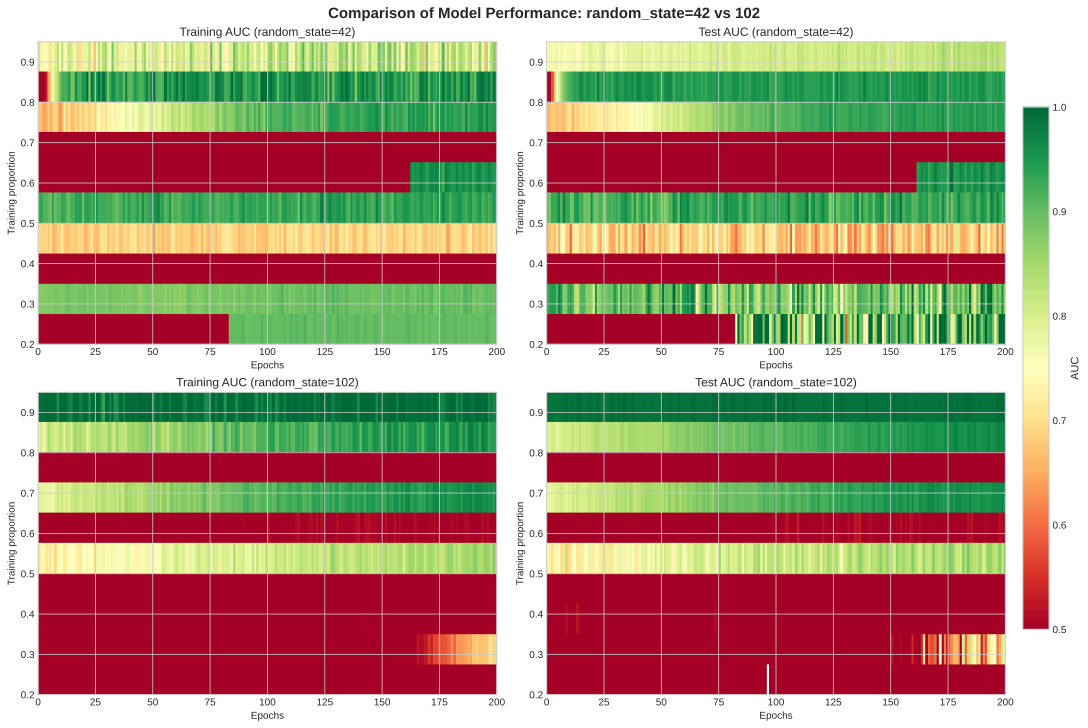

In [23]:
# ---------------------------------------------------------
# Visualization: Training Data (no overlap version)
# ---------------------------------------------------------
fig, ax = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)

# Training AUC (seed 42)
ax[0,0].imshow(train42, aspect='auto', vmin=0.5, vmax=1.0,
               extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0,0].set_title('Training AUC (random_state=42)')
ax[0,0].set_xlabel('Epochs')
ax[0,0].set_ylabel('Training proportion')

# Test AUC (seed 42)
im1 = ax[0,1].imshow(test42, aspect='auto', vmin=0.5, vmax=1.0,
                     extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[0,1].set_title('Test AUC (random_state=42)')
ax[0,1].set_xlabel('Epochs')
ax[0,1].set_ylabel('Training proportion')

# Training AUC (seed 102)
ax[1,0].imshow(train102, aspect='auto', vmin=0.5, vmax=1.0,
               extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1,0].set_title('Training AUC (random_state=102)')
ax[1,0].set_xlabel('Epochs')
ax[1,0].set_ylabel('Training proportion')

# Test AUC (seed 102)
im2 = ax[1,1].imshow(test102, aspect='auto', vmin=0.5, vmax=1.0,
                     extent=[0, epochs, trainSetSizes[0], trainSetSizes[-1]], cmap='RdYlGn')
ax[1,1].set_title('Test AUC (random_state=102)')
ax[1,1].set_xlabel('Epochs')
ax[1,1].set_ylabel('Training proportion')

# Colorbar that respects constrained layout
cbar = fig.colorbar(im2, ax=ax[:,1], shrink=0.8, pad=0.02)
cbar.set_label('AUC', fontsize=11)

plt.suptitle("Comparison of Model Performance: random_state=42 vs 102",
             fontsize=15, weight='bold')
plt.show()
